In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 라이브러리 설치
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install catboost
    !pip install PDPbox
    !pip install shap

In [ ]:
# 필요 라이브러리 가져오기
import numpy as np
import pandas as pd
import pandas_profiling

import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.cluster import KMeans

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')
sns.set(font_scale=0.8)

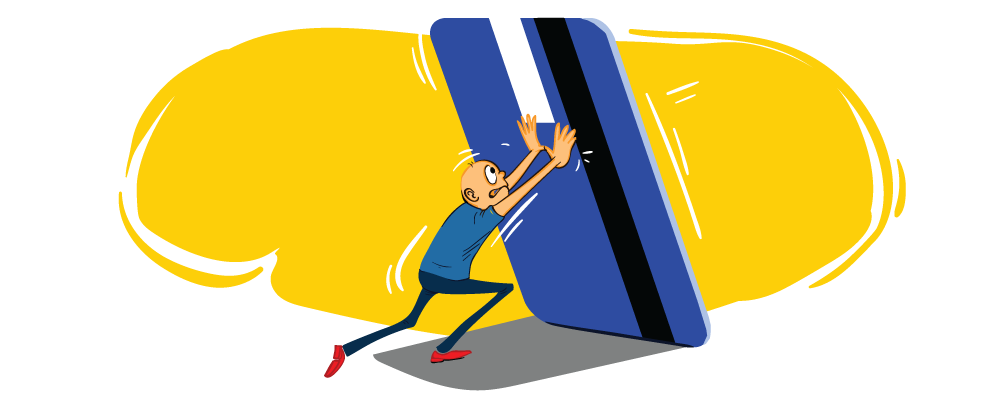

## **신용카드 사용자 연체 예측 Project**
*   신용카드사는 신용카드 신청자가 제출한 개인정보와 데이터를 활용해 신용 점수를 산정합니다. 신용카드사는 이 신용 점수를 활용해 신청자의 향후 채무 불이행과 신용카드 대급 연체 가능성을 예측합니다.
*   연체 가능성 예측을 통해 개인정보 중 쓸모있는 데이터와 쓸모 없는 데이터를 구분하고 향후 연체를 할 것 같은 고객에게 대출한도를 제한하는 등 여러 제안을 할 수 있을 것입니다.
*   신용 등급(credit)를 0, 1, 2점으로 분류하는 다항분류모델을 사용할 예정입니다.




### **데이터 변수 설명**


- index

- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
- edu_type: 교육 수준
- family_type: 결혼 여부
- house_type: 생활 방식
- DAYS_BIRTH: 출생일
> 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
- DAYS_EMPLOYED: 업무 시작일
> 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미, 양수 값은 고용되지 않은 상태를 의미함
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월
> 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


- **credit(타겟 변수): 사용자의 신용카드 대금 연체를 기준으로 한 신용도
   ==> 낮을 수록 높은 신용의 신용카드 사용자를 의미합니다.**

## **데이터 확인**

In [ ]:
# 데이터를 불러옵니다. 대회용 데이터라 submission 파일은 불러오지 않습니다.

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
# sample_submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample_submission.csv")

In [ ]:
train.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [ ]:
# index 칼럼과 value가 하나 밖에 없는 FLAG_MOBIL 칼럼 제거
train = train.drop(['index', 'FLAG_MOBIL'], axis=1)
test = test.drop(['index', 'FLAG_MOBIL'], axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     18286 non-null  object 
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
 17  credit         26457 non-null  float64
dtypes: flo

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
child_num,26457.0,0.428658,0.747326,0.0,0.0,0.0,1.0,19.0
income_total,26457.0,187306.524493,101878.367995,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,26457.0,-15958.053899,4201.589022,-25152.0,-19431.0,-15547.0,-12446.0,-7705.0
DAYS_EMPLOYED,26457.0,59068.750728,137475.427503,-15713.0,-3153.0,-1539.0,-407.0,365243.0
work_phone,26457.0,0.224742,0.417420,0.0,0.0,0.0,0.0,1.0
phone,26457.0,0.294251,0.455714,0.0,0.0,0.0,1.0,1.0
email,26457.0,0.091280,0.288013,0.0,0.0,0.0,0.0,1.0
family_size,26457.0,2.196848,0.916717,1.0,2.0,2.0,3.0,20.0
begin_month,26457.0,-26.123294,16.559550,-60.0,-39.0,-24.0,-12.0,0.0
credit,26457.0,1.519560,0.702283,0.0,1.0,2.0,2.0,2.0


In [ ]:
train.shape, test.shape

# test에는 credit columns이 존재하지 않음을 확인

((26457, 18), (10000, 17))

In [ ]:
# 결측치 확인
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
test.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

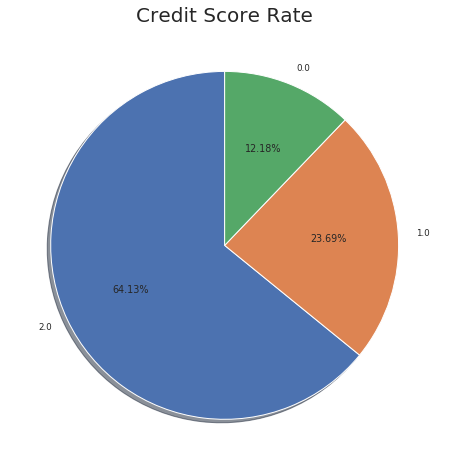

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64


In [ ]:
target = 'credit'


plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Credit Score Rate', size=20)
plt.show()
print(train[target].value_counts())

💳 이번 프로젝트에서는 고객의 신용 등급을 예측하는 모델을 만드는 것이 목표이므로 '**credit**'을 타겟 특성으로 설정합니다. 

위 그래프에 보이는 것처럼 0점, 1점, 2점으로 분류 되는데 2점(신용등급이 안좋은)의 분포가 많음을 확인할 수 있습니다.


모델과 평가지표는 각각 Catboost과 Log Loss를 사용할 예정인데, 이유는 아래과 같습니다.

#### **Catboost**
- Category features를 사용하기 위해서는 One-Hot-Encoding등 데이터를 전처리할 필요가 있었지만 Catboost에서는 사용자가 다른 작업을 하지 않아도 자동으로 이를 변환하여 사용합니다..

- 적은 데이터로도 좋은 결과를 얻을 수 있는 효율적인 방법입니다.
- 학습 시간이 다른 GBDT에 보다는 더 오래 걸리는 대신에 예측 시간이 13-16배 정도 더 빠르다고 합니다.

#### **Log Loss**
- 최종적으로 맞춘 결과만 가지고 성능을 평가할 경우, 얼만큼의 확률로 해당 답을 얻은건지 평가가 불가능합니다.. 답은 맞췄지만 20%의 확률로 그저 찍은거라면 성능이 좋은 모델이라고 할 수 없습니다.

- 이를 보완하기 위해서는 확률 값을 평가 지표로 사용하면 됩니다. Log loss는 모델이 예측한 확률 값을 직접적으로 반영하여 평가합니다.
- 확률 값을 음의 log함수에 넣어 변환을 시킨 값으로 평가하는데, 이는 잘못 예측할 수록, 패널티를 부여하기 위함입니다.

[Catboost 주요 개념과 특징](https://dailyheumsi.tistory.com/136)

## **Categorical Variable EDA**

In [ ]:
# 신용등급에 따른 차이를 보기 위한 데이터 분류
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

In [ ]:
# Categorical 그래프 함수 정의
def cat_plot(column):

  f, ax = plt.subplots(1, 3, figsize=(16, 4))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

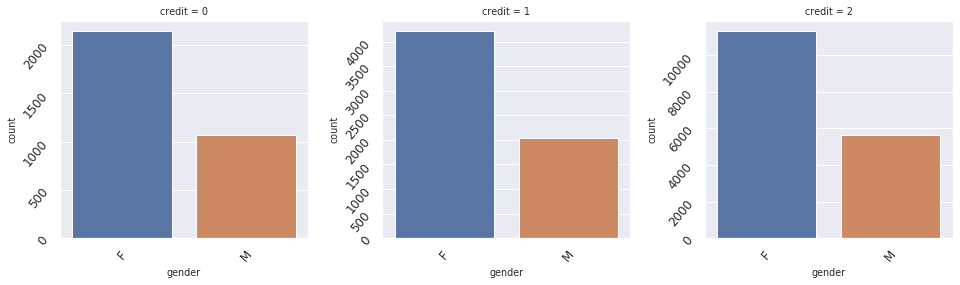

In [ ]:
# 신용등급에 따른 성별차이 확인 >> 모든 등급에서 남성이 더 많음.
cat_plot("gender")

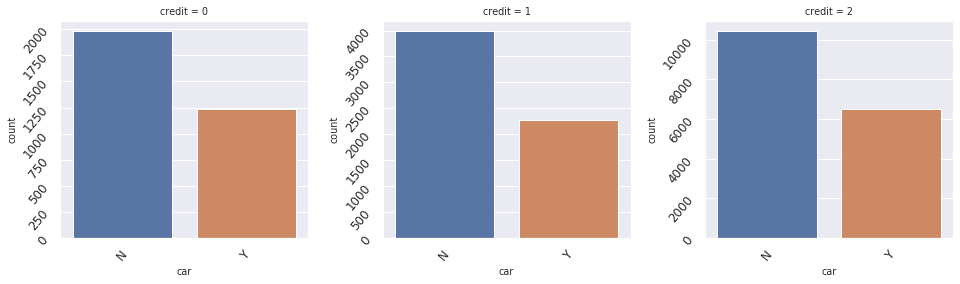

In [ ]:
# 신용등급에 따른 차소유여부 확인 >> 모든 등급에서 차가 없는 사람이 더 많음
cat_plot("car")

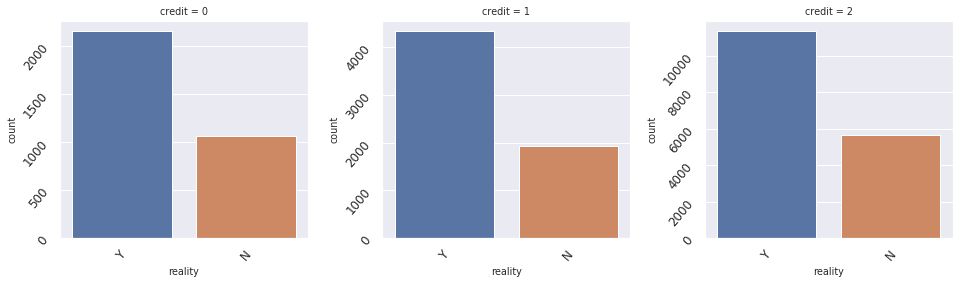

In [ ]:
# 신용등급에 따른 부동산소유여부 확인 >> 모든 등급에서 부동산이 없는 사람이 더 많음
cat_plot("reality")

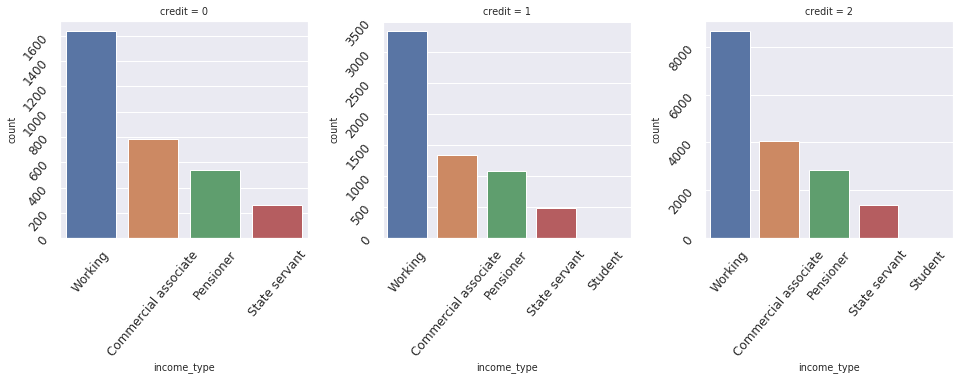

In [ ]:
# 신용등급에 따른 소득 분류의 차이 확인 >> 모든 등급에서 근로소득자가 가장 많음
cat_plot("income_type")

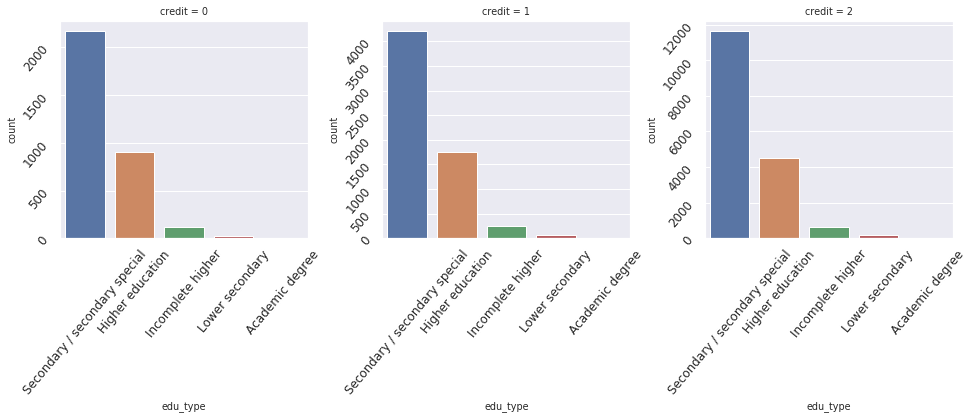

In [ ]:
# 신용등급에 따른 교육 수준 차이 확인 > 모든 등급에서 Secondary가 가장 많고, 그 다음으로 Higher이 많음.
cat_plot("edu_type")

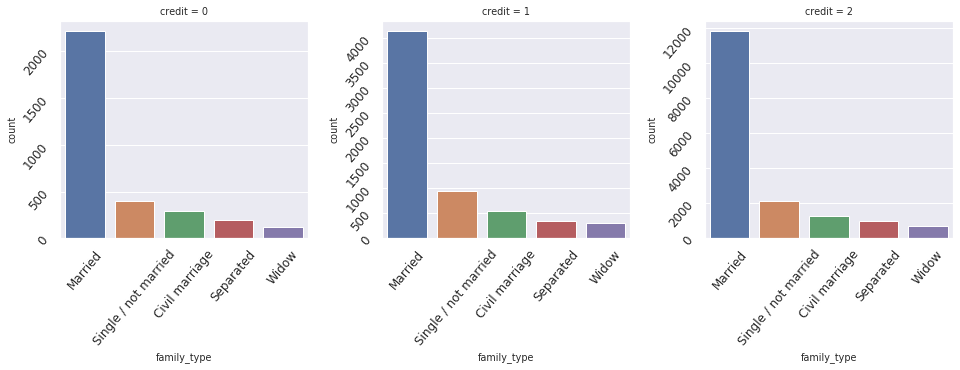

In [ ]:
# 신용등급에 따른 결혼 형태의 차이 확인 > 모든 등급에서 결혼한 비율이 가장 많음.
cat_plot("family_type")

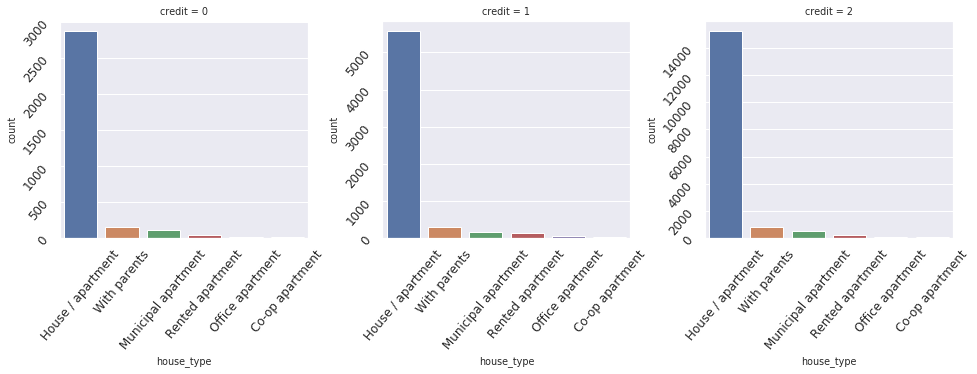

In [ ]:
# 신용등급에 따른 자가 형태의 차이 확인 > 모든 등급에서 House/apartment가 가장 많음.
cat_plot("house_type")

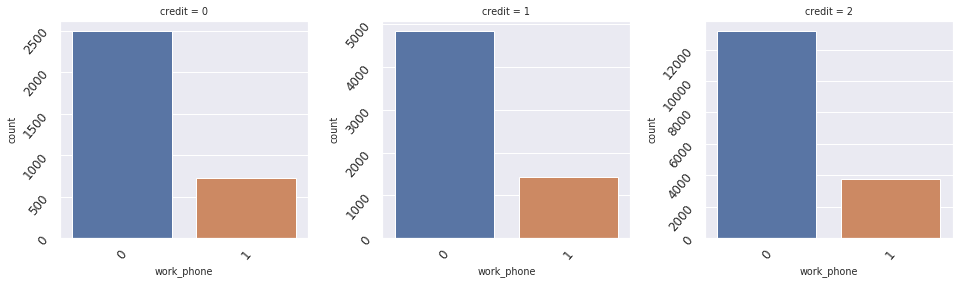

In [ ]:
# 신용등급에 따른 업무용 핸드폰 소유여부의 차이 확인 > 모든 등급에서 업무용 핸드폰을 소유하지 않은 비율이 더 많음
cat_plot("work_phone")

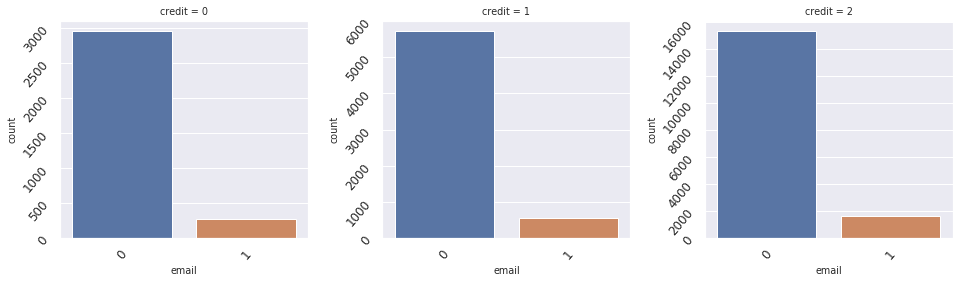

In [ ]:
# 신용등급에 따른 이메일 소유여부의 차이 확인 > 모든 등급에서 이메일을 갖고 있는 사람이 많음.
cat_plot("email")

In [ ]:
# 'ouccyp_type'칼럼의 결측치 처리
train_0 = train_0.fillna({'occyp_type':'untitled'})
train_1 = train_1.fillna({'occyp_type':'untitled'})
train_2 = train_2.fillna({'occyp_type':'untitled'})

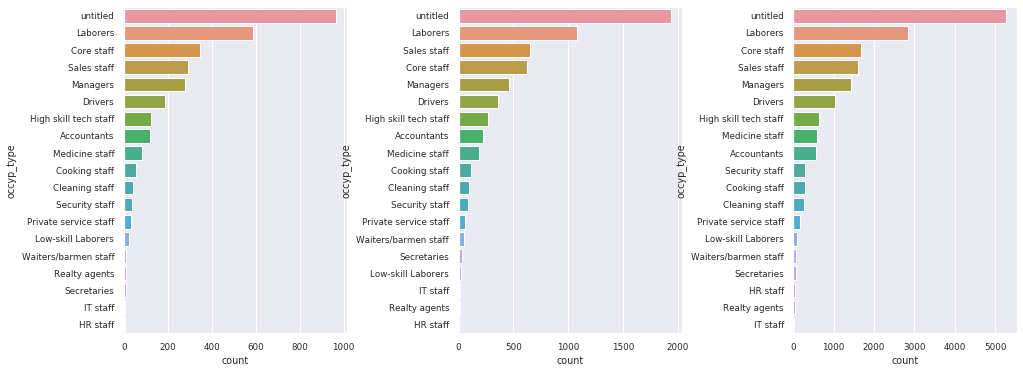

In [ ]:
# 신용등급에 따른 직업유형 차이 확인 >> 모든 등급에서  untitle > Laborers > Staff 순으로 분포가 형성됨을 확인

f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

## **Numerical Variable EDA**
한눈에 파악하기 위해 그래프를 겹쳐서 진행

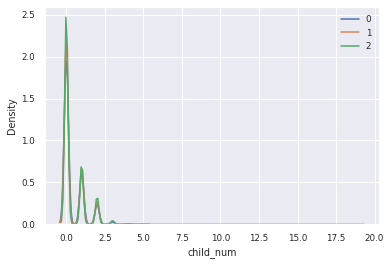

In [ ]:
# 신용등급에 따른 자녀 수 차이 확인 >> 모든 등급에 아이 수가 0명이 가장 높음.

sns.distplot(train_0['child_num'],label='0', hist=False)
sns.distplot(train_1['child_num'],label='1', hist=False)
sns.distplot(train_2['child_num'],label='2', hist=False)
plt.legend()

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
child_num,26457.0,0.428658,0.747326,0.0,0.0,0.0,1.0,19.0
income_total,26457.0,187306.524493,101878.367995,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,26457.0,-15958.053899,4201.589022,-25152.0,-19431.0,-15547.0,-12446.0,-7705.0
DAYS_EMPLOYED,26457.0,59068.750728,137475.427503,-15713.0,-3153.0,-1539.0,-407.0,365243.0
work_phone,26457.0,0.224742,0.417420,0.0,0.0,0.0,0.0,1.0
phone,26457.0,0.294251,0.455714,0.0,0.0,0.0,1.0,1.0
email,26457.0,0.091280,0.288013,0.0,0.0,0.0,0.0,1.0
family_size,26457.0,2.196848,0.916717,1.0,2.0,2.0,3.0,20.0
begin_month,26457.0,-26.123294,16.559550,-60.0,-39.0,-24.0,-12.0,0.0
credit,26457.0,1.519560,0.702283,0.0,1.0,2.0,2.0,2.0


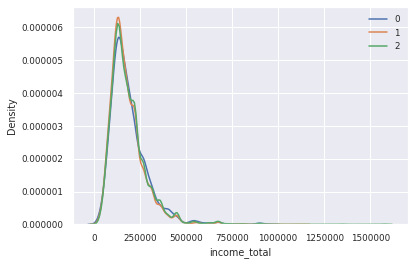

In [ ]:
# 신용등급에 따른 연간 소득의 차이 확인 >> 모든 등급에서 약 180000정도가 가장 높음.

sns.distplot(train_0['income_total'],label='0', hist=False)
sns.distplot(train_1['income_total'],label='1', hist=False)
sns.distplot(train_2['income_total'],label='2', hist=False)
plt.legend()

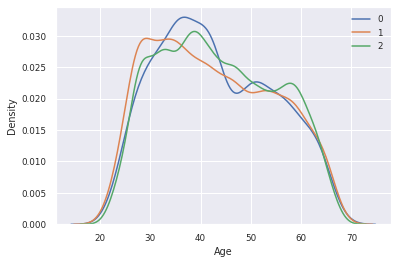

In [ ]:
# 신용등급에 따른 나이 차이 확인 >> 등급별로 약간의 차이가 있지만 20대 후반부터 40대 초반까지가 모든 등급에서 가장 높음

train_0['Age'] = abs(train_0['DAYS_BIRTH'])/365
train_1['Age'] = abs(train_1['DAYS_BIRTH'])/365
train_2['Age'] = abs(train_2['DAYS_BIRTH'])/365

train_0 = train_0.astype({'Age': 'int'})
train_1 = train_1.astype({'Age': 'int'})
train_2 = train_2.astype({'Age': 'int'})

sns.distplot(train_0['Age'],label='0', hist=False)
sns.distplot(train_1['Age'],label='1', hist=False)
sns.distplot(train_2['Age'],label='2', hist=False)
plt.legend()

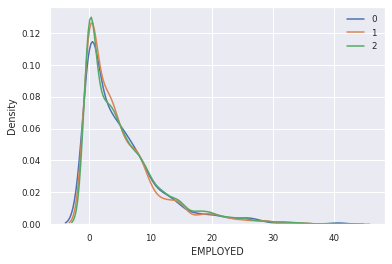

In [ ]:
# 신용등급에 따른 고용일 차이 확인 >> 모든 등급에서 무직자의 비율이 가장 많고 일을 한지 10년이 넘어가면 비율이 많이 줄어듬.
# 양수는 고용되지 않은 상태로 무직을 의미하기 때문에 0으로 대체

train_0['EMPLOYED']= train_0['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_1['EMPLOYED']= train_1['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_2['EMPLOYED']= train_2['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

train_0['EMPLOYED'] = abs(train_0['EMPLOYED'])/365
train_1['EMPLOYED'] = abs(train_1['EMPLOYED'])/365
train_2['EMPLOYED'] = abs(train_2['EMPLOYED'])/365

train_0 = train_0.astype({'EMPLOYED': 'int'})
train_1 = train_1.astype({'EMPLOYED': 'int'})
train_2 = train_2.astype({'EMPLOYED': 'int'})

sns.distplot(train_0['EMPLOYED'],label='0', hist=False)
sns.distplot(train_1['EMPLOYED'],label='1', hist=False)
sns.distplot(train_2['EMPLOYED'],label='2', hist=False)
plt.legend()

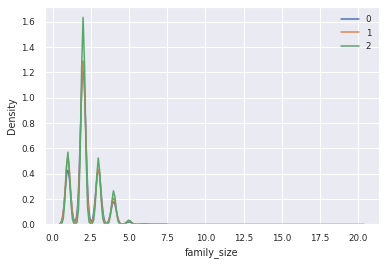

In [ ]:
# 신용등급에 따른 가족 규모 차이 확인 >> 모든 등급에서 2명의 비율이 가장 많음. 위의 데이터 중 결혼한 비율이 많고, 아이 수가 0인 경우가 많은 것과 일맥상통함

sns.distplot(train_0['family_size'],label='0', hist=False)
sns.distplot(train_1['family_size'],label='1', hist=False)
sns.distplot(train_2['family_size'],label='2', hist=False)
plt.legend()

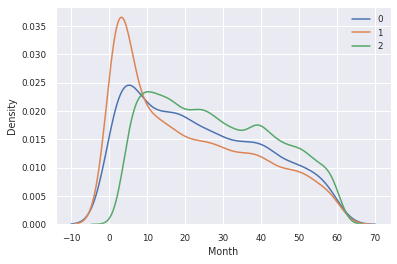

In [ ]:
# 신용등급에 따른 신용카드 발급기간(월) 차이 확인 >>  모든 등급에서 10개월까지의 발급기간 비율이 가장 높았고 그 뒤로는 발급기간이 점점 줄어듬

train_0['Month'] = abs(train_0['begin_month'])
train_1['Month'] = abs(train_1['begin_month'])
train_2['Month'] = abs(train_2['begin_month'])

train_0 = train_0.astype({'Month': 'int'})
train_1 = train_1.astype({'Month': 'int'})
train_2 = train_2.astype({'Month': 'int'})

sns.distplot(train_0['Month'],label='0', hist=False)
sns.distplot(train_1['Month'],label='1', hist=False)
sns.distplot(train_2['Month'],label='2', hist=False)
plt.legend()

### EDA를 통해 다음을 확인할 수 있었습니다.
1) 등급에 따른 feature들의 차이가 거의 없거나 조금만 존재합니다.

2) 약간의 차이를 보이는 feature들에 집중해야 하고 feature를 지울수록 예측률이 떨어집니다. 또한 해당 feature들의 outlier를 제거할 경우 모델 예측률이 떨어질 수도 있으니 유의해야 합니다.

3) 모든 등급별 feature중 가장 많은 분포를 차지하는 값들이 정해져 있습니다. (예: 성별은 남자)

## **Feature Engineering**

In [ ]:
# 결측치 처리
train.fillna('NaN', inplace=True), test.fillna('NaN', inplace=True)

# 양수인 데이터는 현재 무직자로 판단, 0 처리
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

# 음수값 -> 양수 변환
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [ ]:
# 파생변수와 다중공선을 보이는 컬럼 삭제
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,0,0,0,NaN,2.0,6.0,1.0,9190,22.034820,6.0,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Laborers,3.0,5.0,1.0,9840,25.152439,4.0,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,0,1,0,Managers,2.0,22.0,2.0,14653,30.710435,8.0,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0,1,0,Sales staff,2.0,37.0,0.0,12996,15.581717,1.0,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,0,0,0,Managers,2.0,26.0,2.0,12932,12.179091,11.0,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...


## **Scaling, Encoding**

In [ ]:
# Numeric, Category 컬럼 분류
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [ ]:
print("숫자형 특성: ", numerical_feats)
print("범주형 특성: ", categorical_feats)

숫자형 특성:  ['income_total', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'before_EMPLOYED', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_m', 'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED', 'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean']
범주형 특성:  ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']


In [ ]:
# 숫자형 특성 income_total에 log scale 적용

for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
# 범주형 특성은 ordinal_encoder 변환, ID는 변환 후 정수 처리

encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
# 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
# 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID,cluster
0,1,1,1,12.218505,1,1,1,1,-0.538417,-0.645705,-0.316937,1,-0.214735,-1.215231,1.0,-0.939166,0.627113,0.166663,-1.348609,-0.452819,0.442911,-0.443446,0.994411,-1.230195,-1.077139,-0.032484,0.002331,1,22
1,1,1,2,12.419174,1,2,2,2,-0.538417,-0.645705,3.155199,2,0.876135,-1.275620,1.0,-0.805573,0.928345,-0.418605,-0.459118,-1.060808,0.442911,-0.443446,-0.250447,-0.424410,-1.077139,1.190283,-0.253877,2,29
2,2,2,2,13.017007,2,1,1,2,-0.538417,1.548696,-0.316937,3,-0.214735,-0.249003,2.0,0.183634,1.465371,0.751931,-0.459118,0.763158,-1.582589,0.451462,0.994411,-0.424410,-0.223654,1.186662,1.693298,3,35
3,1,1,2,12.218505,1,2,1,2,-0.538417,1.548696,-0.316937,4,-0.214735,0.656836,0.0,-0.156926,0.003599,-1.296506,-1.348609,-0.192253,1.310982,1.346370,-0.094839,1.187160,0.629831,0.101195,0.002331,4,22
4,1,2,2,11.967193,3,1,1,2,-0.538417,-0.645705,-0.316937,3,-0.214735,-0.007446,2.0,-0.170080,-0.325170,1.629832,1.319863,-0.192253,1.021625,-1.338354,-0.094839,1.455755,-1.077139,-0.282900,-0.305118,5,29


## **Modeling**

In [ ]:
# 피쳐, 타겟 나누기
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
# parameter를 default로 두는 것이 logloss가 가장 낮았음
# fold 수를 3부터 20까지 돌려보고 최적 fold 15로 판단 후 선택

%%time 

seed = 42
n_fold = 15
n_class = 3

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
  
  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0356609	test: 1.0338653	best: 1.0338653 (0)	total: 191ms	remaining: 3m 10s
100:	learn: 0.7050292	test: 0.6575580	best: 0.6575580 (100)	total: 10.3s	remaining: 1m 31s
200:	learn: 0.6853641	test: 0.6534058	best: 0.6530041 (186)	total: 21.7s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6530040824
bestIteration = 186

Shrink model to first 187 iterations.
CV Log Loss Score: 0.653004

----------------- Fold 1 -----------------

Learning rate set to 0.115128
0:	learn: 1.0340680	test: 1.0334101	best: 1.0334101 (0)	total: 128ms	remaining: 2m 7s
100:	learn: 0.7057303	test: 0.6548602	best: 0.6548602 (100)	total: 10.4s	remaining: 1m 32s
200:	learn: 0.6875179	test: 0.6514054	best: 0.6510038 (190)	total: 21.9s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6510037723
bestIteration = 190

Shrink model to first 191 iterations.
CV Log 

In [ ]:
# LGBM 모델을 통해 예측하는 baseline 만들기
# 데이터 분리는 StratifiedKFold 를 사용하여 y값 분포를 비슷하게 분리시킴 > 5-fold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
# lightgbm의 default parameter로 훈련.
# 30번 이상 개선 없을 경우 중단.
# 각 5개의 fold를 훈련하여 저장

%%time

random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb


----------------- Fold 0 -----------------

Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.641677	valid_1's multi_logloss: 0.73611
[200]	training's multi_logloss: 0.551787	valid_1's multi_logloss: 0.709601
[300]	training's multi_logloss: 0.486513	valid_1's multi_logloss: 0.69651
[400]	training's multi_logloss: 0.436407	valid_1's multi_logloss: 0.690966
Early stopping, best iteration is:
[411]	training's multi_logloss: 0.431261	valid_1's multi_logloss: 0.690571

----------------- Fold 1 -----------------

Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.635575	valid_1's multi_logloss: 0.74956
[200]	training's multi_logloss: 0.545588	valid_1's multi_logloss: 0.731829
[300]	training's multi_logloss: 0.479843	valid_1's multi_logloss: 0.726202
Early stopping, best iteration is:
[271]	training's multi_logloss: 0.496869	valid_1's multi_logloss: 0.725979

----------------- Fold 2 -----------------


💳 교차검증을 통해 평균값을 냈을 때 Log Loss 값은 **0.666364**으로 LGBM 베이스라인모델 낮음을 확인할 수 있었음. Log Loss 함수는 0에 가까울수록 좋은 모델임. 



## **Feautre Importance**

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

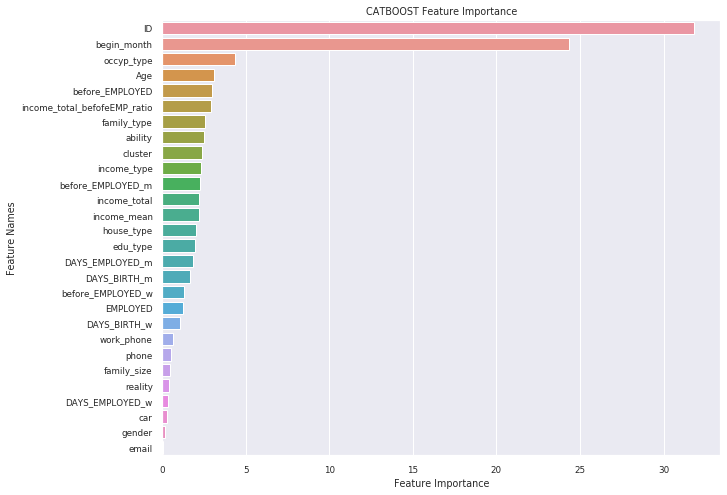

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

새롭게 종합한 feature인 **'ID'**의 중요도가 상당히 높게 나오는 것을 볼 수 있었습니다.

그 다음은 **'begin_month'**이고 3번째 feature부터는 중요도가 5%미만으로 많이 떨어지는 것을 확인할 수 있었습니다.

## 💳 **결론**

### **Feature Enginnering**
1) Feature 전처리(양수 치환) → Feature 추가 → Feature 후처리(제거 및 Log적용) → Clustering적용 순으로 진행하였습니다. 

2) Feature 전처리에서는 Nan 데이터 처리, Family_size/ Flag_mobile 제거 및 음수값을 양수 값으로 치환 하였습니다. 

3) 치환된 값을 기준으로 총 12개의 Feature를 추가하였습니다. 

4) 추가한 Feature 중에 Permutation Feature Importance가 가장 높은 변수는 ID로 중복 데이터를 처리 하기 위한 변수로 test데이터와 train 데이터를 비교했을때 중복되지 않은 값(신규)에 대해서는 모두 -1로 처리 하였습니다.

5) 추가한 데이터와 비교했을 때 다중공선을 보이는 기존 Feature 3개(child_num, days_birth, days_employed)를 제거하였고, 이렇게 선별된 27개의 Feature(기존+추가)를 K-means 클러스터에 적용하여 36개의 Category를 Feature로 적용하여 총 28개의 Feature를 사용하였습니다.

### **Modeling**
1) Feature Engineering을 통해 선별된 28개의 Feature를 Catboost 모델에 적용하였고 LGBM baseline 모델과 비교하였습니다. Catboost는 XGBoost와 같은 균형 트리 분할 방법을 사용 합니다.

2) 이전 스프린트 등을 통해 같은 데이터로 다른 모델들은 GridSearchCV를 적용하여 최적의 파라미터를 적용하였을 때와, CatBoost로 기본 파라미터를 사용하였을 때를 비교하면 CatBoost가 가장 좋은 성능을 보여 주었습니다. 학습 시 데이터를 K-fold를 이용하여 여러개의 train/validation set으로 나눠서 적용하였는데, fold의 수를 3개에서 20개 까지 돌려보고 가장 좋은 결과를 보여준 15로 설정 하였습니다.

### **Insight**
1) EDA 시, target에 분포에 대한 feature들의 상관관계 상 뚜렷한 차이를 볼 수가 없었기 때문에 수치 기반 데이터의 변형을 통해 데이터를 추가하여 성능을 향상시킬 수 있었습니다. 또한 중복 데이터도 존재하였는데 K-means 클러스터를 통해 일정부분 해결할 수 있었습니다.

2) Catboost의 기본 파마미터만 사용해서 결과가 좋은 것을 상기해 볼 때, 파라미터에 너무 시간을 할애하지 말고 여러 모델을 빠르게 학습 후 Feature Engineering을 적용하여 의미 있는 Feature들을 찾아내거나 추가하는게 더 좋은 결과를 보여 줄것으로 생각됩니다.
